<a href="https://colab.research.google.com/github/MattLeRoi/nlp_product_sentiment_project/blob/main/index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# global_superstore

In [1]:
pip install pandas openpyxl

In [2]:
import pandas as pd

# Read the entire Excel file into a DataFrame (defaults to the first sheet)
df = pd.read_excel('https://github.com/MattLeRoi/new_project/raw/refs/heads/main/Global%20Superstore%20Data.xlsx')

In [3]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Postal Code,City,...,Product ID,Product Name,Sub-Category,Category,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority
0,24599,IN-2017-CA120551-42816,2017-03-22,2017-03-29,Standard Class,CA-120551,Cathy Armstrong,Home Office,NaN,Herat,...,FUR-BO-4861,"Ikea Library with Doors, Mobile",Bookcases,Furniture,731.82,2,0.0,102.42,39.66,Medium
1,29465,ID-2015-BD116051-42248,2015-09-01,2015-09-04,Second Class,BD-116051,Brian Dahlen,Consumer,NaN,Herat,...,OFF-SU-2988,"Acme Scissors, Easy Grip",Supplies,Office Supplies,243.54,9,0.0,104.49,18.72,Medium
2,24598,IN-2017-CA120551-42816,2017-03-22,2017-03-29,Standard Class,CA-120551,Cathy Armstrong,Home Office,NaN,Herat,...,TEC-MA-4211,"Epson Receipt Printer, White",Machines,Technology,346.32,3,0.0,13.77,14.10,Medium
3,24597,IN-2017-CA120551-42816,2017-03-22,2017-03-29,Standard Class,CA-120551,Cathy Armstrong,Home Office,NaN,Herat,...,FUR-FU-5726,"Rubbermaid Door Stop, Erganomic",Furnishings,Furniture,169.68,4,0.0,79.68,11.01,Medium
4,29464,ID-2015-BD116051-42248,2015-09-01,2015-09-04,Second Class,BD-116051,Brian Dahlen,Consumer,NaN,Herat,...,OFF-EN-3664,"Cameo Interoffice Envelope, with clear poly wi...",Envelopes,Office Supplies,203.88,4,0.0,24.36,5.72,Medium


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Row ID          51290 non-null  int64         
 1   Order ID        51290 non-null  object        
 2   Order Date      51290 non-null  datetime64[ns]
 3   Ship Date       51290 non-null  datetime64[ns]
 4   Ship Mode       51290 non-null  object        
 5   Customer ID     51290 non-null  object        
 6   Customer Name   51290 non-null  object        
 7   Segment         51290 non-null  object        
 8   Postal Code     9994 non-null   float64       
 9   City            51290 non-null  object        
 10  State           51290 non-null  object        
 11  Country         51290 non-null  object        
 12  Region          51290 non-null  object        
 13  Market          51290 non-null  object        
 14  Product ID      51290 non-null  object        
 15  Pr

In [5]:
df.drop('Postal Code', axis=1, inplace=True)

In [6]:
df

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,...,Product ID,Product Name,Sub-Category,Category,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority
0,24599,IN-2017-CA120551-42816,2017-03-22,2017-03-29,Standard Class,CA-120551,Cathy Armstrong,Home Office,Herat,Hirat,...,FUR-BO-4861,"Ikea Library with Doors, Mobile",Bookcases,Furniture,731.820,2,0.0,102.420,39.66,Medium
1,29465,ID-2015-BD116051-42248,2015-09-01,2015-09-04,Second Class,BD-116051,Brian Dahlen,Consumer,Herat,Hirat,...,OFF-SU-2988,"Acme Scissors, Easy Grip",Supplies,Office Supplies,243.540,9,0.0,104.490,18.72,Medium
2,24598,IN-2017-CA120551-42816,2017-03-22,2017-03-29,Standard Class,CA-120551,Cathy Armstrong,Home Office,Herat,Hirat,...,TEC-MA-4211,"Epson Receipt Printer, White",Machines,Technology,346.320,3,0.0,13.770,14.10,Medium
3,24597,IN-2017-CA120551-42816,2017-03-22,2017-03-29,Standard Class,CA-120551,Cathy Armstrong,Home Office,Herat,Hirat,...,FUR-FU-5726,"Rubbermaid Door Stop, Erganomic",Furnishings,Furniture,169.680,4,0.0,79.680,11.01,Medium
4,29464,ID-2015-BD116051-42248,2015-09-01,2015-09-04,Second Class,BD-116051,Brian Dahlen,Consumer,Herat,Hirat,...,OFF-EN-3664,"Cameo Interoffice Envelope, with clear poly wi...",Envelopes,Office Supplies,203.880,4,0.0,24.360,5.72,Medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51285,46231,ZA-2014-AS285147-41718,2014-03-20,2014-03-25,Standard Class,AS-285147,Alejandro Savely,Corporate,Harare,Harare,...,OFF-AR-5911,"Sanford Highlighters, Easy-Erase",Art,Office Supplies,9.612,2,0.7,-21.168,1.02,Medium
51286,50122,ZA-2017-HG4965147-42876,2017-05-21,2017-05-23,Second Class,HG-4965147,Henry Goldwyn,Corporate,Mutare,Manicaland,...,OFF-LA-3260,"Avery Color Coded Labels, 5000 Label Set",Labels,Office Supplies,4.104,1,0.7,-4.806,1.80,High
51287,50297,ZA-2016-EB3870147-42499,2016-05-09,2016-05-15,Standard Class,EB-3870147,Emily Burns,Consumer,Mutare,Manicaland,...,OFF-AR-5922,"Sanford Pencil Sharpener, Fluorescent",Art,Office Supplies,7.749,1,0.7,-9.051,1.46,Medium
51288,47164,ZA-2015-JG5115147-42040,2015-02-05,2015-02-10,Standard Class,JG-5115147,Jack Garza,Consumer,Kadoma,Mashonaland West,...,TEC-MA-5542,"Panasonic Card Printer, Durable",Machines,Technology,104.364,2,0.7,-173.976,7.46,Medium


In [7]:
df['Country']

,Country
0,Afghanistan
1,Afghanistan
2,Afghanistan
3,Afghanistan
4,Afghanistan
...,...
51285,Zimbabwe
51286,Zimbabwe
51287,Zimbabwe
51288,Zimbabwe


# health_fitness_tracking_365days

In [8]:
import pandas as pd
health = pd.read_csv('https://github.com/MattLeRoi/new_project/raw/refs/heads/main/Tech_Use_Stress_Wellness.csv')
health.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 25 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   user_id                           5000 non-null   int64  
 1   age                               5000 non-null   int64  
 2   gender                            5000 non-null   object 
 3   daily_screen_time_hours           5000 non-null   float64
 4   phone_usage_hours                 5000 non-null   float64
 5   laptop_usage_hours                5000 non-null   float64
 6   tablet_usage_hours                5000 non-null   float64
 7   tv_usage_hours                    5000 non-null   float64
 8   social_media_hours                5000 non-null   float64
 9   work_related_hours                5000 non-null   float64
 10  entertainment_hours               5000 non-null   float64
 11  gaming_hours                      5000 non-null   float64
 12  sleep_

(array([443., 413., 515., 543., 508., 489., 470., 470., 408., 741.]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <BarContainer object of 10 artists>)

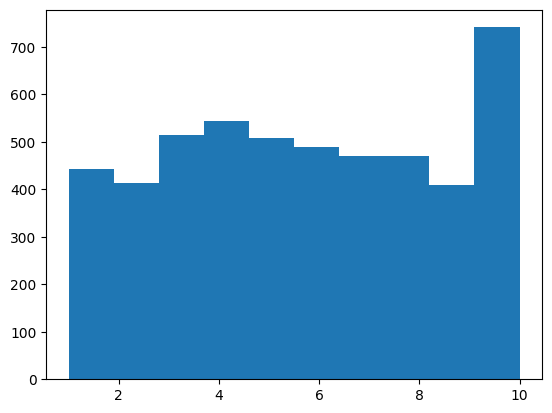

In [17]:
import matplotlib.pyplot as plt

plt.hist(health.stress_level)

In [9]:
health.head()

,user_id,age,gender,daily_screen_time_hours,phone_usage_hours,laptop_usage_hours,tablet_usage_hours,tv_usage_hours,social_media_hours,work_related_hours,...,stress_level,physical_activity_hours_per_week,location_type,mental_health_score,uses_wellness_apps,eats_healthy,caffeine_intake_mg_per_day,weekly_anxiety_score,weekly_depression_score,mindfulness_minutes_per_day
0,1,53,Male,6.8,2.9,2.1,0.5,2.0,2.3,3.0,...,3,4.4,Rural,79.0,True,True,150.4,7.0,3.0,14.0
1,2,66,Female,4.1,2.1,1.6,0.4,0.8,2.8,3.5,...,4,4.1,Rural,71.0,True,True,124.1,7.0,10.0,15.5
2,3,43,Male,4.7,3.6,0.0,0.5,1.4,3.7,3.6,...,6,1.4,Urban,67.0,True,True,218.3,11.0,7.0,19.5
3,4,29,Female,6.0,4.5,0.0,0.2,1.3,4.5,4.0,...,10,0.0,Rural,55.0,True,True,133.7,17.0,14.0,13.9
4,5,57,Male,6.7,3.4,2.0,0.8,1.2,3.8,3.5,...,6,2.8,Urban,62.0,False,False,192.8,5.0,8.0,26.7


In [31]:
from sklearn.model_selection import train_test_split

# health.loc[health['stress_level'] == 10, 'stress_level_cat'] = 2
health.loc[health['stress_level'] >= 7, 'stress_level_cat'] = 1
health.loc[health['stress_level'] < 7, 'stress_level_cat'] = 0

X = health.drop(['stress_level', 'location_type', 'gender', 'stress_level_cat'], axis=1)
y = health['stress_level_cat'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [33]:
from sklearn.metrics import classification_report

y_pred =  model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.95      0.96       604
         1.0       0.93      0.96      0.95       396

    accuracy                           0.96      1000
   macro avg       0.95      0.96      0.95      1000
weighted avg       0.96      0.96      0.96      1000

